## Using logistic regression to predict whether a patient has depression and/or anxiety

### Import packages

In [1]:
import numpy as np
import os
import pandas as pd
import re

### Importing dataset

In [2]:
def get_responses_data():
    
    #Get relative directory to find path
    path = os.path.join(os.getcwd(), 'data', 'response_format_cleaned_ds1.csv')
    responses = pd.read_csv(path, sep=';', header=0)
    responses.drop(responses.columns[[0]], axis=1, inplace=True)
    
    #Drop rows with NA values 
    responses = responses[~responses.wor_all_words.str.contains("NA NA NA NA NA")]
    responses = responses[~responses.wor_all_phraces.str.contains("NA NA NA NA NA")]
    responses = responses[~responses.dep_all_phraces.str.contains("NA NA NA NA NA")]
    responses = responses[~responses.dep_all_words.str.contains("NA NA NA NA NA")]
    responses = responses.reset_index(drop=True)
    responses.dropna(subset=['Wortext'], inplace=True)
    responses.dropna(subset=['Deptext'], inplace=True)
    return responses

get_responses_data()

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,sequence1,seqOne,Dep5words[Word1],...,wor_all_selected,wor_all_selected1,minidep_scale,minidep_diagnose,depression_episodes,miniGAD_scale,miniGAD_symptoms_scale,miniGAD_diagnose,minidiagnose_category,minidiagnose_category_number
0,434.0,2020-08-07 11:46:22,15.0,en,6.593644e+08,2020-08-07 11:38:22,2020-08-07 11:46:22,2.0,1.0,motivated,...,NA NA happy NA NA NA NA NA NA NA NA NA NA care...,happy carefree satisfied ...,0.0,0,0,0,0,0,NoDi,0
1,184.0,2020-08-07 11:58:36,15.0,en,2.803892e+08,2020-08-07 11:34:31,2020-08-07 11:58:36,2.0,1.0,connected,...,anxious NA NA NA NA NA NA NA NA NA NA tense NA...,anxious tense fearful sad fe...,3.0,0,0,8,5,0,NoDi,0
2,330.0,2020-08-07 11:51:54,15.0,en,6.770686e+07,2020-08-07 11:36:32,2020-08-07 11:51:54,1.0,1.0,Yes,...,anxious NA NA NA NA NA worried NA NA NA NA NA ...,anxious worried scared sad mon...,7.0,0,5,9,5,0,NoDi,0
3,630.0,2020-08-07 13:22:42,15.0,en,1.176643e+09,2020-08-07 12:55:26,2020-08-07 13:22:42,3.0,1.0,minor,...,anxious NA NA NA NA concerned NA NA NA NA NA t...,anxious concerned tense scared ...,3.0,0,5,8,5,0,NoDi,0
4,400.0,2020-08-07 12:04:52,15.0,en,1.012492e+09,2020-08-07 11:37:19,2020-08-07 12:04:52,1.0,1.0,family,...,NA NA NA NA NA concerned NA NA NA NA NA tense ...,concerned tense sad tired ...,4.0,0,2,7,4,1,GAD,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,32.0,2020-08-07 12:02:58,15.0,en,1.363161e+09,2020-08-07 11:45:11,2020-08-07 12:02:58,3.0,1.0,Worried,...,anxious NA NA NA NA NA NA NA NA NA NA NA scare...,anxious scared uneasy fearful ...,9.0,1,1,0,0,0,Dep,1
958,344.0,2020-08-07 13:45:57,15.0,en,1.283747e+08,2020-08-07 13:32:04,2020-08-07 13:45:57,3.0,1.0,Tired,...,NA NA NA nervous NA NA worried NA NA NA NA NA ...,nervous worried stress anxie...,7.0,1,7,11,6,1,BOTH,3
959,297.0,2020-08-07 13:11:46,15.0,en,9.695994e+08,2020-08-07 12:52:04,2020-08-07 13:11:46,3.0,1.0,Unsettled,...,NA NA NA NA NA NA NA NA stressed NA NA NA scar...,stressed scared fearful anxi...,7.0,1,2,10,5,1,BOTH,3
960,241.0,2020-08-07 12:51:07,15.0,en,1.976520e+09,2020-08-07 12:28:54,2020-08-07 12:51:07,2.0,1.0,Despair,...,anxious NA NA NA NA NA worried NA stressed NA ...,anxious worried stressed uneasy ...,8.0,1,1,11,6,1,BOTH,3


### LSA

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 


def get_co_matrix():
    """
    Using 5-gram contexts from the database, a co-occurrence (word by word) matrix was set up, 
    where the rows contained the 120,000 most common words in the n-gram database and the columns 
    consisted of the 10,000 most common words in the n-gram database.

    The variable 'space' is a matrix of the semantic space with dimentions reduced to 512.
    """
    path = os.path.join(os.getcwd(), 'data', 'spaceEnglish1.csv')
    space = pd.read_csv(path, encoding= 'unicode_escape')
    space.set_index('words', inplace=True)
    space.drop(space.columns[[0]], axis=1, inplace=True)
    space.dropna(inplace=True)
    space = space[~space.index.duplicated(keep='first')]
    return space

"""
Cleans the string from punctuations and removes all words which are not represented in the semantic space. 
"""

space=get_co_matrix() 
words_in_space = set(space.index.values)
STOP_WORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        try:
            tokens = word_tokenize(text)
            words = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.isalpha()]
            words = [w for w in words if not w in STOP_WORDS]
            cleaned_words = [w for w in words if w in words_in_space]  
            return cleaned_words
        except Exception as e: 
            print(e)
    elif math.isnan(text):
        return []



In [4]:
"""
Controlling for artifacts relating to frequently occurring words.

1) Calculate, from Google N-gram, a frequency weighted average of all semantic representations in the space.
   (So that the weighting is proportional to how frequently the words occur in Google N-gram.)
2) Subtract this mean prior to aggregating each word, and then add to the final value.
"""

space_mean = pd.Series.to_numpy(space.mean())

def aggregating_words(responses):
    res_arr = np.zeros(512)
    
    for word in responses:
        word_arr = pd.Series.to_numpy(space.loc[word])
        res_arr = res_arr + (word_arr - space_mean)
    
    res_arr += space_mean    
    res_arr = res_arr / res_arr.sum() # Normalizing aggregated vector
    return res_arr

In [5]:
def aggregate_cell(text):
    words_in_cell = pd.Series.apply(text, clean_text)
    cell_vectors = pd.Series.apply(words_in_cell, aggregating_words)
    return cell_vectors


def concat_vectors(row):
    return np.concatenate(row.values).ravel()


In [6]:
def get_x_lsa_dep():
    responses=get_responses_data()
    dep_columns = ['Deptext', 'dep_all_phraces', 'dep_all_words', 'dep_all_selected1']
    df_dep_responses = responses[dep_columns]
    df_dep_aggregated = df_dep_responses.apply(aggregate_cell, axis=1)
    x_dep_lsa=pd.DataFrame(list(df_dep_aggregated.apply(concat_vectors, axis=1)))
    return x_dep_lsa


In [7]:
def get_x_lsa_wor():
    responses=get_responses_data()
    wor_columns = ['Wortext', 'wor_all_phraces', 'wor_all_words', 'wor_all_selected1']
    df_wor_responses = responses[wor_columns]
    df_wor_aggregated = df_wor_responses.apply(aggregate_cell, axis=1)
    x_wor_lsa=pd.DataFrame(list(df_wor_aggregated.apply(concat_vectors, axis=1)))
    return x_wor_lsa

### The categorical variable, whether someone is diagnosed with dep/worry or not

In [84]:
def get_binary_y(responses):
    dep_diag = responses[['minidep_diagnose']]
    wor_diag = responses[['miniGAD_diagnose']]
    
    #Checking for NaN values
    dep_diag.isnull().values.any() #false
    wor_diag.isnull().values.any() #false

    #Create y - variables
    y_wor_diag = wor_diag.values
    y_dep_diag = dep_diag.values
    return y_dep_diag, y_wor_diag

## Logistic regression 

Get data

In [85]:
responses=get_responses_data()

#Depression data
X_dep_lsa=get_x_lsa_dep()
y_dep = get_binary_y(responses)[0]
#Worry data
X_wor_lsa=get_x_lsa_wor()
y_wor = get_binary_y(responses)[1]

print("Respondents with depression diagnose: {} out of {}".format(int(y_dep.sum()), len(y_dep))) #unbalanced
print("Respondents with worry/anxiety diagnose: {} out of {}".format(int(y_wor.sum()), len(y_wor))) #not as unbalanced

Respondents with depression diagnose: 320 out of 952
Respondents with worry/anxiety diagnose: 493 out of 952


Split data into training and test data

In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report, accuracy_score, balanced_accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline


def split_train_test(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, stratify=y)
    
    #normalize test and train data separately 
    X_train=preprocessing.normalize(X_train, norm='l2')
    X_test=preprocessing.normalize(X_test, norm='l2')
    
    y_test=y_test.ravel() 
    y_train=y_train.ravel()
    return X_train, X_test, y_train, y_test

In [14]:
def get_eval(y_test,y_pred):
    acc=metrics.accuracy_score(y_test, y_pred )
    mcc=metrics.matthews_corrcoef(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)
    #cm=confusion_matrix(y_test,y_pred)
    cm=pd.crosstab(y_test, y_pred, margins=True, rownames=['Actual'], colnames=['Predicted'])
    cr = classification_report(y_test,y_pred)
    return acc, mcc, bal_acc, cm, cr


#### Baseline predictions

In [16]:
#Depression
X_train_dep, X_test_dep, y_train_dep, y_test_dep= split_train_test(X_dep_lsa, y_dep)
#use log to predict. 
model = LogisticRegression()
model.fit(X_train_dep, y_train_dep)
y_pred_dep = model.predict(X_test_dep)
acc_dep, mcc_dep, bal_acc_dep, cm_dep, cr_dep= get_eval(y_test_dep, y_pred_dep)
print(cr_dep)

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       127
           1       0.45      0.16      0.23        64

    accuracy                           0.65       191
   macro avg       0.57      0.53      0.50       191
weighted avg       0.60      0.65      0.59       191



In [17]:
#Worry 
X_train_wor, X_test_wor, y_train_wor, y_test_wor= split_train_test(X_wor_lsa, y_wor)
model = LogisticRegression()
model.fit(X_train_wor, y_train_wor)
y_pred_wor = model.predict(X_test_wor)
acc_wor, mcc_wor, bal_acc_wor, cm_wor, cr_wor= get_eval(y_test_wor, y_pred_wor)
print(cr_wor)

              precision    recall  f1-score   support

           0       0.51      0.34      0.41        92
           1       0.53      0.70      0.60        99

    accuracy                           0.52       191
   macro avg       0.52      0.52      0.50       191
weighted avg       0.52      0.52      0.51       191



Using dummy classifier to make prediction

In [87]:
from sklearn.dummy import DummyClassifier

In [100]:
#Stratified generates random predictions by respecting the training set class distribution.
dummy_model= DummyClassifier(strategy='stratified', random_state=0)
#Depression
X_train_dep, X_test_dep, y_train_dep, y_test_dep= split_train_test(X_dep_lsa, y_dep)
dummy_model.fit(X_train_dep, y_train_dep)
y_pred_dep=dummy_model.predict(X_test_dep) 
acc_dep, mcc_dep, bal_acc_dep, cm_dep, cr_dep= get_eval(y_test_dep, y_pred_dep)
print(cm_dep)
print(cr_dep)

Predicted    0   1  All
Actual                 
0           83  44  127
1           46  18   64
All        129  62  191
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       127
           1       0.29      0.28      0.29        64

    accuracy                           0.53       191
   macro avg       0.47      0.47      0.47       191
weighted avg       0.53      0.53      0.53       191



In [98]:
#Stratified generates random predictions by respecting the training set class distribution.
dummy_model= DummyClassifier(strategy='stratified', random_state=0)
#Worry
X_train_wor, X_test_wor, y_train_wor, y_test_wor= split_train_test(X_wor_lsa, y_wor)
dummy_model.fit(X_train_wor, y_train_wor)
y_pred_wor=dummy_model.predict(X_test_wor)
acc_wor, mcc_wor, bal_acc_wor, cm_wor, cr_wor= get_eval(y_test_wor, y_pred_wor)
print(cm_wor)
print(cr_wor)

Predicted    0   1  All
Actual                 
0           50  42   92
1           53  46   99
All        103  88  191
              precision    recall  f1-score   support

           0       0.49      0.54      0.51        92
           1       0.52      0.46      0.49        99

    accuracy                           0.50       191
   macro avg       0.50      0.50      0.50       191
weighted avg       0.50      0.50      0.50       191



### Dimension reduction - PCA

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Analysing number of components to use for PCA

In [57]:
def get_scores(model, X, y):
    score = np.mean(cross_val_score(model, X, y, n_jobs=-1, scoring='f1')) 
    return score

def get_nbr_components_pca(X, y, start=1, stop=300):
    pca_scores=[]
    models = dict()
    start, stop=start, stop
    X_train, X_test, y_train, y_test= split_train_test(X, y)
    for i in range(start,stop): 
        model=make_pipeline(PCA(n_components=i), LogisticRegression())
        score = get_scores(model, X_train, y_train)
        pca_scores.append(score)
    n_components_pca=np.argmax(pca_scores)+1+start
    print(start) #todelete
    print(np.argmax(pca_scores)) #todelete 
    return pca_scores, n_components_pca


def plot_nbr_components_pca(pca_scores, start, stop):
    if len(pca_scores)>0:
        n=np.arange(start, stop, step=1, dtype=int)
        plt.figure()
        plt.plot(n, pca_scores)
        plt.xlabel("Number of components")
        plt.ylabel("PCA score")
        plt.show()



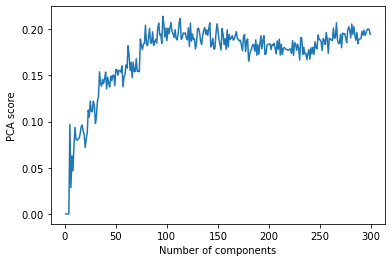

Nbr of components to use for PCA dimension reduction on dep. dataset:  96


In [50]:
start, stop=1,300
pca_scores_dep, nbr_components_dep= get_nbr_components_pca(X_dep_lsa, y_dep, start, stop)
plot_nbr_components_pca(pca_scores_dep, start, stop)
print("Nbr of components to use for PCA dimension reduction on dep. dataset: ", nbr_components_dep)
#with f1-scoring: [96, 198, 266]. With accuracy scoring: #3 #50 #199#14 #4

1
5


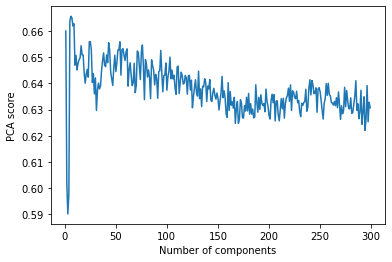

Nbr of components to use for PCA dim. reduc. on worry dataset:  7


In [101]:
start, stop=1, 300
pca_scores_wor, nbr_components_wor=get_nbr_components_pca(X_wor_lsa, y_wor, start, stop)
plot_nbr_components_pca(pca_scores_wor, start, stop)
print("Nbr of components to use for PCA dim. reduc. on worry dataset: ", nbr_components_wor)
#with f1-scoring: 8 #296 

#### Analysing number of components to use for PCA using GridSearchCV

Depression

In [63]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('model', LogisticRegression())])

#Define a set of possible values to try for the given model
param_grid = {
    'pca__n_components': np.arange(start=1, stop=300, step=1, dtype=int) #[3,4,5,16, 96, 199, 198, 266, 300],
    'model__C': [0.0001, 0.001,0.01, 0.1, 1, 10,100, 1000] 
}

grid_searcher = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1') 
X_train, X_test, y_train, y_test = split_train_test(X_dep_lsa, y_dep)
grid_searcher.fit(X_train, y_train)


/Users/alexandraantgren/opt/anaconda3/envs/ml2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


'\nparams=grid_searcher.best_params_\nprint("Best parameters: {} ".format(params))\n\n#identifies the best estimator from the combination of parameter values\nestimator = grid_searcher.best_estimator_\ny_pred = estimator.predict(X_test)\nprint(estimator)\nprint(y_pred)\n\n#evaluate result\nacc, mcc, bal_acc, cm, cr= get_eval(y_test, y_pred)\nprint(cr)\n\n\n#c=0.0001, n_components=3, accuracy=68.367% #127 c=10000.0 n=3  #3 #0.001 66.49 % \n#198, c:1\n#c=20, n=266 #c=35, n=300, '

In [64]:
#identifies the best estimator from the combination of parameter values
estimator = grid_searcher.best_estimator_
y_pred = estimator.predict(X_test)
print(estimator)

#evaluate result
acc, mcc, bal_acc, cm, cr= get_eval(y_test, y_pred)
print(cr)

#c=0.0001, n_components=3, #127 c=10000.0, c=0.001 n=3 
#198, c:1 #c=20, n=266 #c=35, n=300
#With f1: c=1, n=300

Best parameters: {'model__C': 1, 'pca__n_components': 300} 
Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=300)),
                ('model', LogisticRegression(C=1))])
[0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0
 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1
 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1
 1 0 1 1 1 0]
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       127
           1       0.44      0.45      0.45        64

    accuracy                           0.62       191
   macro avg       0.58      0.58      0.58       191
weighted avg       0.63      0.62      0.62       191



Worry

In [67]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('model', LogisticRegression())])

#Define a set of possible values to try for the given model
param_grid = {
    'pca__n_components': [3,4,5,16, 96, 199, 198, 266, 300], #np.arange(start=1, stop=300, step=1, dtype=int)
    'model__C': [0.0001, 0.001,0.01, 0.1, 1, 10,100, 1000] 
}

grid_searcher = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1') 
X_train, X_test, y_train, y_test = split_train_test(X_wor_lsa, y_wor)
grid_searcher.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                      1000],
                         'pca__n_components': [3, 4, 5, 16, 96, 199, 198, 266,
                                               300]},
             scoring='f1')

In [68]:
#identifies the best estimator from the combination of parameter values
estimator = grid_searcher.best_estimator_
y_pred = estimator.predict(X_test)
print(estimator)

#evaluate result
acc, mcc, bal_acc, cm, cr= get_eval(y_test, y_pred)
print(cr)
#n=16, c=0.0001


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=16)),
                ('model', LogisticRegression(C=0.0001))])
[1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0
 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.75      0.33      0.45        92
           1       0.59      0.90      0.71        99

    accuracy                           0.62       191
   macro avg       0.67      0.61      0.58       191
weighted avg       0.67      0.62      0.59       191



# Dimension reduction using UMAP

In [70]:
import umap

In [78]:
#Analysing parameters to use for UMAP pipeline with GridSearchCV
#question: add random state to umap?
#question: pca before umap?

#C=0.0001, PCA=16 
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=16)), ('umap', umap.UMAP()), ('model', LogisticRegression(C=0.0001))])
#define a set of possible values to try for the given model
param_grid = {
    'umap__n_neighbors': [2,3,4, 5], #[2,3,4,5], #2, 5, 10, 20, 50, 100, 200
    'umap__n_components': [3,4,5] #[150] [200], [250] [100] [96] ,
    #'umap__min_dist': [0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9], ##can range from 0.0 through to 0.99.
    #'model__C': [0.0001, 0.001, 0.1, 1, 10, 15, 20], #[10 ** k for k in range(-3, 4)],
}

grid_searcher = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1')
X_train, X_test, y_train, y_test= split_train_test(X_dep_lsa, y_dep)
grid_searcher.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=16)),
                                       ('umap',
                                        UMAP(dens_frac=0.0, dens_lambda=0.0)),
                                       ('model',
                                        LogisticRegression(C=0.0001))]),
             n_jobs=-1,
             param_grid={'umap__n_components': [3, 4, 5],
                         'umap__n_neighbors': [2, 3, 4, 5]},
             scoring='f1')

In [82]:
#identifies the best estimator from the combination of parameter values
estimator = grid_searcher.best_estimator_
print(estimator)
y_pred = estimator.predict(X_test)#n_components=4, n_neighbors=5, 
acc, mcc, bal_acc, cm, cr= get_eval(y_test,y_pred)
print(cr)
print(mcc)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=16)),
                ('umap',
                 UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=4,
                      n_neighbors=5)),
                ('model', LogisticRegression(C=0.0001))])
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       127
           1       0.59      0.42      0.49        64

    accuracy                           0.71       191
   macro avg       0.67      0.64      0.64       191
weighted avg       0.69      0.71      0.69       191



## Evaluation on depression data 

In [103]:
chosen_c_value= 1 #0.01 0.001  #35
chosen_n_components= 96 #220#300 #199 # 14 #50 #3 #5 

X_train, X_test, y_train, y_test= split_train_test(X_dep_lsa, y_dep)

#normalize
model = make_pipeline(StandardScaler(), umap.UMAP(n_neighbors=5,
                      min_dist=0.3, n_components=chosen_n_components), LogisticRegression()) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc, mcc, bal_acc, cm, cr= get_eval(y_test,y_pred)
print(cr)


/Users/alexandraantgren/opt/anaconda3/envs/ml2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.76      0.66      0.71       127
           1       0.46      0.58      0.51        64

    accuracy                           0.63       191
   macro avg       0.61      0.62      0.61       191
weighted avg       0.66      0.63      0.64       191



### Evaluation on worry data